#Variational Autoencoders

In [ ]:
%tensorflow_version 2.x

##The heart disease dataset revisited

--2020-09-08 02:39:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [application/x-httpd-php]
Saving to: ‘processed.cleveland.data’

processed.cleveland 100%[===================>]  18.03K  --.-KB/s    in 0.06s   

2020-09-08 02:39:58 (283 KB/s) - ‘processed.cleveland.data’ saved [18461/18461]



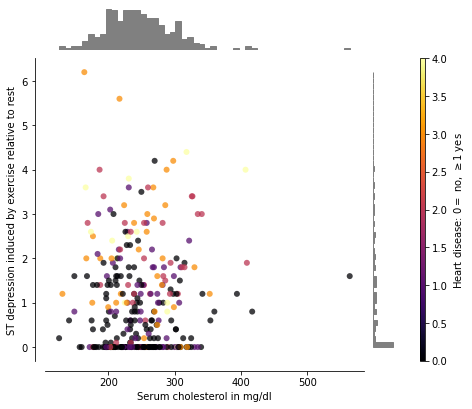

In [ ]:
# Inspired by this post: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
# Modified by: Pablo Rivas
# Comes from Chapter 3

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler, minmax_scale

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

df = pd.read_csv('processed.cleveland.data', header=None)
df = df.apply(pd.to_numeric, errors='coerce').dropna()

X = df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values
y_full = df[13].values

y = minmax_scale(y_full)


cmap = getattr(cm, 'inferno', cm.hot_r)

def create_axes(title, figsize=(6, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.74
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.12
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)


    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            ax_colorbar)


def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 4], X[:, 9], alpha=0.75, marker='o', lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 9], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 4], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')
    
def make_plot(X):
    title = ""
    ax_zoom_out, ax_colorbar = create_axes(title)
    plot_distribution(ax_zoom_out, X, y, hist_nbins=50,
                      x0_label="Serum cholesterol in mg/dl",
                      x1_label="ST depression induced by exercise relative to rest")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Heart disease: $0=$ no, $\geq 1$ yes')
    plt.savefig('ch.9.heart.png', bbox_inches='tight', dpi=350)
    
make_plot(X)


##The re-parametrization trick and sampling

In [ ]:
from tensorflow.keras import backend as K

def sampling(z_params):
  z_mean, z_log_var = z_params
  batch = K.shape(z_mean)[0]
  dims = K.int_shape(z_mean)[1]
  epsilon = K.random_normal(shape=(batch, dims)) 
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

##Learning the posterior's parameters in the encoder

In [ ]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
scaler.fit(X)
x_train = scaler.transform(X)
original_dim = x_train.shape[1]

In [ ]:
input_shape = (original_dim, )
intermediate_dim = 13
batch_size = 18 # comes from ceil(sqrt(x_train.shape[0])) 
latent_dim = 2 # useful for visualization
epochs = 500

In [ ]:
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

inputs = Input(shape=input_shape) 
bn = BatchNormalization()(inputs)

dp = Dropout(0.2)(bn)
x = Dense(intermediate_dim, activation='sigmoid')(dp)
x = Dropout(0.2)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z_params = [z_mean, z_log_var]
z = Lambda(sampling, output_shape=(latent_dim,))(z_params) 
encoder = Model(inputs, [z_mean, z_log_var, z])


##Modeling the decoder

In [ ]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs) 
r_outputs = Dense(original_dim)(x) # reconstruction outputs 
decoder = Model(latent_inputs, r_outputs)

In [ ]:
outputs = decoder(encoder(inputs)[2]) # it is index 2 since we want z 
vae = Model(inputs, outputs)

##Minimizing the loss

In [ ]:
from tensorflow.keras.losses import mse 
r_loss = mse(inputs, outputs)

In [ ]:
from tensorflow.keras.losses import binary_crossentropy 
r_loss = binary_crossentropy(inputs, outputs)

In [ ]:
r_loss = original_dim * r_loss

In [ ]:
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var) 
kl_loss = 0.5 * K.sum(kl_loss, axis=-1)

In [ ]:
vae_loss = K.mean(r_loss + kl_loss) 
vae.add_loss(vae_loss)

##Training a VAE


In [ ]:
vae.compile(optimizer='adam')

In [ ]:
hist = vae.fit(x_train, epochs=epochs, batch_size=batch_size,
               validation_data=(x_train, None))

Epoch 1/500
17/17 [==============================] - 0s 20ms/step - loss: 1.8541 - val_loss: 4.2253
Epoch 2/500
17/17 [==============================] - 0s 7ms/step - loss: 1.4289 - val_loss: 0.8945
Epoch 3/500
17/17 [==============================] - 0s 7ms/step - loss: 0.9626 - val_loss: 0.9799
Epoch 4/500
17/17 [==============================] - 0s 7ms/step - loss: 0.4743 - val_loss: 0.9162
Epoch 5/500
17/17 [==============================] - 0s 7ms/step - loss: 0.3106 - val_loss: -1.1127
Epoch 6/500
17/17 [==============================] - 0s 7ms/step - loss: 0.4802 - val_loss: 0.7268
Epoch 7/500
17/17 [==============================] - 0s 6ms/step - loss: -0.6548 - val_loss: -0.1497
Epoch 8/500
17/17 [==============================] - 0s 6ms/step - loss: 0.3633 - val_loss: 0.6652
Epoch 9/500
17/17 [==============================] - 0s 7ms/step - loss: 0.2966 - val_loss: -1.8619
Epoch 10/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0920 - val_loss: -0.2537
Epo

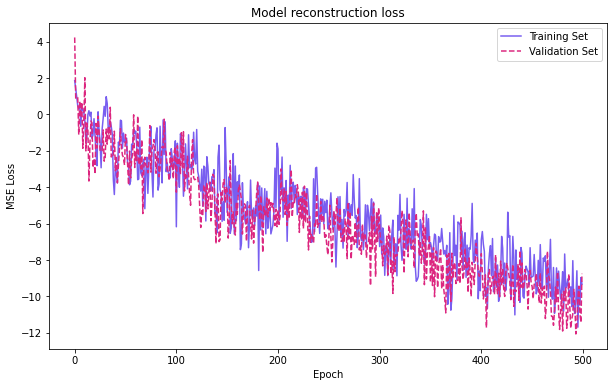

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], '--', color='#dc267f')
plt.title('Model reconstruction loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.savefig('ch.9.vae.heart.loss.png', dpi=350, bbox_inches='tight')
plt.show()


[ 0.93618065  0.69109474 -2.24062879  0.75038004 -0.27644339  2.43042728
  1.01019851  0.01749443 -0.69641941  1.06896529  2.26414539 -0.72197605
  0.65587737]
[-0.32491452  0.10554516 -0.22033115 -0.18241715  0.19544603  0.10372129
  0.18911788 -0.01131247  0.17380494 -0.46417966 -0.32322755 -0.04469399
  0.08750571]
[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   6. ]
[ 51.6   0.7   2.9 128.5 257.5   0.2   1.2 149.3   0.4   0.5   1.4   0.6
   4.9]


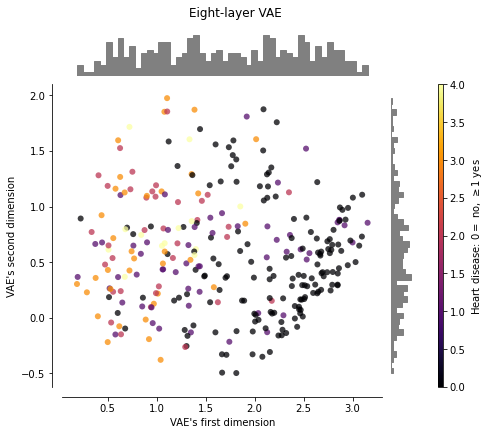

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

encdd = encoder.predict(x_train)
x_hat = decoder.predict(encdd[0])

print(x_train[0])
print(x_hat[0])

np.set_printoptions(suppress=True)
print(np.around(scaler.inverse_transform(x_train[0]), decimals=1))
print(np.around(scaler.inverse_transform(x_hat[0]), decimals=1))

def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.75, marker='o', lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

def make_plot(X):
    title = "Eight-layer VAE"
    ax_zoom_out, ax_colorbar = create_axes(title)
    plot_distribution(ax_zoom_out, X, y, hist_nbins=50,
                      x0_label="VAE's first dimension",
                      x1_label="VAE's second dimension")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Heart disease: $0=$ no, $\geq 1$ yes')
    plt.savefig('ch.9.vae.heart.8l.png', bbox_inches='tight', dpi=350)
    
make_plot(encdd[0])

##Generating data from the VAE

In [ ]:
encdd = encoder.predict(x_train) 
x_hat = decoder.predict(encdd[0])

In [ ]:
import numpy as np 
print(np.around(scaler.inverse_transform(x_train[0]), decimals=1)) 
print(np.around(scaler.inverse_transform(x_hat[0]), decimals=1))


[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   6. ]
[ 51.6   0.7   2.9 128.5 257.5   0.2   1.2 149.3   0.4   0.5   1.4   0.6
   4.9]


In [ ]:
def generate_samples(N = 10, latent_dim = 2):
  noise = np.random.uniform(-2.0, 2.0, (N,latent_dim))
  gen = decoder.predict(noise)
  return gen

gen = generate_samples(10, latent_dim)
print(np.around(scaler.inverse_transform(gen), decimals=1))


[[ 55.6   0.9   1.9 125.5 203.8  -0.1   0.7 127.8   0.1   0.6   2.    1.4
    6.5]
 [ 53.7   0.8   2.7 125.2 255.2   0.2   1.1 143.4   0.2   0.1   1.5   0.8
    5.2]
 [ 52.    0.7   3.1 129.  254.    0.2   1.2 149.5   0.4   0.6   1.5   0.7
    4.8]
 [ 48.5   0.9   2.4 123.4 192.7  -0.5   0.7 141.1   0.1   0.9   1.7   1.
    5.4]
 [ 52.1   0.8   3.1 128.5 229.   -0.1   0.9 145.5   0.2   0.8   1.6   0.9
    4.9]
 [ 57.3   1.    1.8 125.6 208.7   0.    0.6 125.4   0.1   0.4   2.    1.4
    6.7]
 [ 50.5   1.    1.8 122.2 175.4  -0.5   0.6 130.9   0.1   0.8   2.    1.3
    6.2]
 [ 50.5   0.8   3.3 129.3 232.4  -0.    0.8 150.1   0.2   0.5   1.5   0.7
    4.8]
 [ 49.8   0.8   3.4 127.5 214.4  -0.2   0.8 149.5   0.1   0.4   1.5   0.8
    4.6]
 [ 57.1   1.    1.7 125.1 202.9  -0.    0.6 124.3   0.1   0.4   2.1   1.5
    6.8]]


##Comparing a deep and shallow VAE on MNIST

###Shallow VAE

In [ ]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
import numpy as np
import matplotlib.pyplot as plt

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "ch.9.vae.s.mnist.latent_space.png")
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename, bbox_inches='tight', dpi=350)
    plt.show()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
X = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(X)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_8[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_8[0][0]                    
____________________________________________________________________________________________

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 403972      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          403728      encoder[0][2]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
____________________________________________________________________________________________

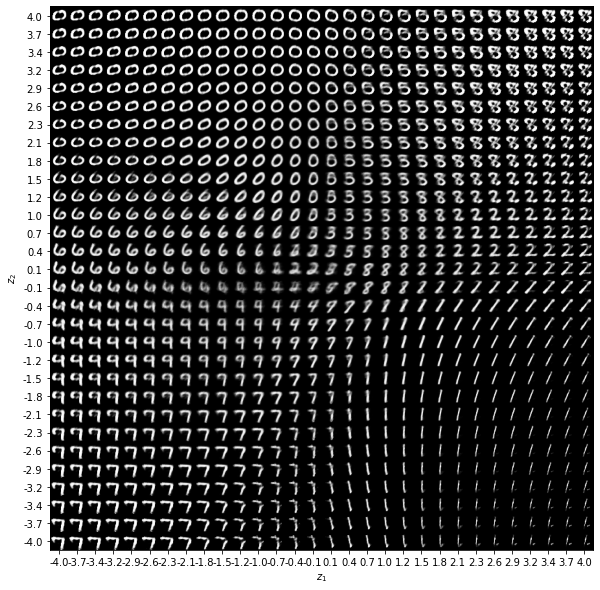

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")


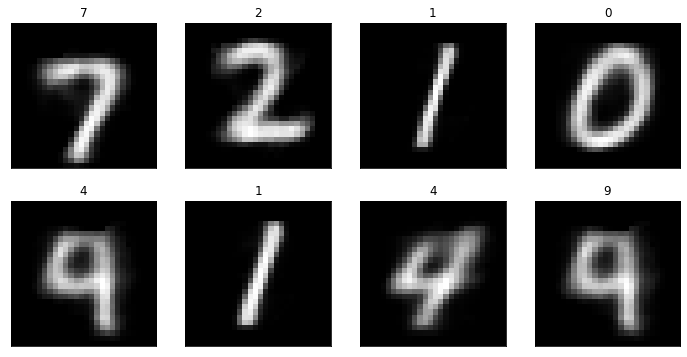

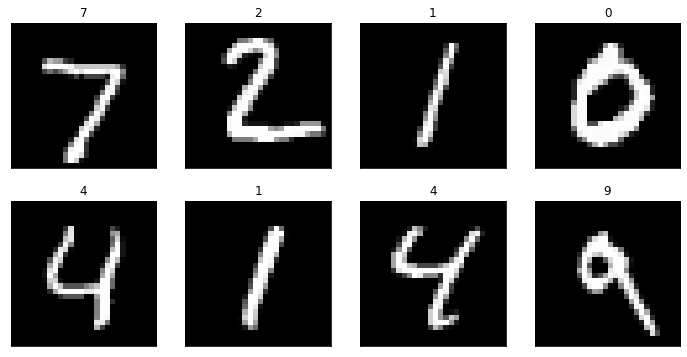

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

encdd = encoder.predict(x_test)
x_hat = decoder.predict(encdd[0])

plt.figure(figsize=(12,6))
for i, (img, y) in enumerate(zip(x_hat[0:8].reshape(8, 28, 28), y_test[0:8])):
  plt.subplot(241 + i)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(y)
plt.savefig('ch.9.vae.s.mnist.reconstructed.png', bbox_inches='tight', dpi=350)
plt.show()

plt.figure(figsize=(12,6))
for i, (img, y) in enumerate(zip(x_test[0:8].reshape(8, 28, 28), y_test[0:8])):
  plt.subplot(241 + i)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(y)
plt.savefig('ch.9.vae.s.mnist.original.png', bbox_inches='tight', dpi=350)
plt.show()

(10000, 2)


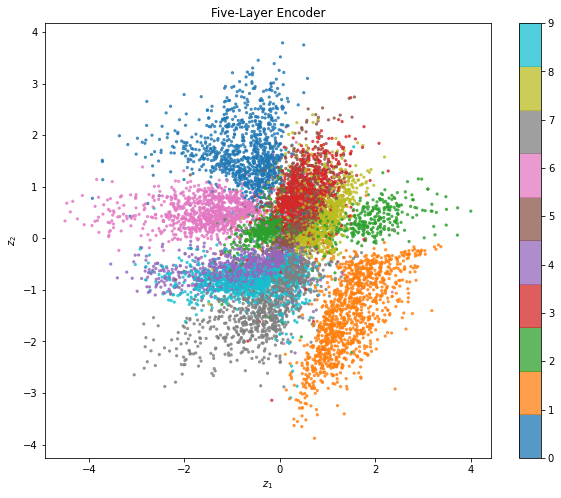

In [ ]:
import matplotlib.pyplot as plt

y_ = list(map(int, y_test))
X_ = encdd[0]

print(X_.shape)

plt.figure(figsize=(10,8))
plt.title('Five-Layer Encoder')
plt.scatter(X_[:,0], X_[:,1], s=5.0, c=y_, alpha=0.75, cmap='tab10')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.colorbar()
plt.savefig('ch.9.vae.s.mnist.5l.png', bbox_inches='tight', dpi=350)

###Deep VAE

In [ ]:
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
import numpy as np
import matplotlib.pyplot as plt


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder = models
    x_test, y_test = data

    filename = os.path.join(model_name, "ch.9.vae.d.mnist.latent_space.png")
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-2.5, 2.5, n)
    grid_y = np.linspace(-2.5, 2.5, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("$z_1$")
    plt.ylabel("$z_2$")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename, bbox_inches='tight', dpi=350)
    plt.show()

inpt_dim =  28*28
ltnt_dim = 2

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28*28))
x_test = x_test.reshape((len(x_test), 28*28))
print(x_train.shape)
print(x_test.shape)

inpt_vec = Input(shape=(inpt_dim,))
el1 = Dropout(0.1)(inpt_vec)
el2 = Dense(512)(el1)
el3 = Activation('relu')(el2)
el4 = Dropout(0.1)(el3)
el5 = Dense(512)(el4)
el6 = BatchNormalization()(el5)
el7 = Activation('relu')(el6)
el8 = Dropout(0.1)(el7)

el9 = Dense(256)(el8)
el10 = Activation('relu')(el9)
el11 = Dropout(0.1)(el10)
el12 = Dense(256)(el11)
el13 = BatchNormalization()(el12)
el14 = Activation('relu')(el13)
el15 = Dropout(0.1)(el14)

el16 = Dense(128)(el15)
el17 = Activation('relu')(el16)
el18 = Dropout(0.1)(el17)
el19 = Dense(ltnt_dim)(el18)
el20 = BatchNormalization()(el19)
el21 = Activation('sigmoid')(el20)

z_mean = Dense(ltnt_dim, name='z_mean')(el21)
z_log_var = Dense(ltnt_dim, name='z_log_var')(el21)

z = Lambda(sampling, name='z')([z_mean, z_log_var])

encoder = Model(inpt_vec, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

ltnt_vec = Input(shape=(ltnt_dim,))
dl1 = Dense(128)(ltnt_vec)
dl2 = BatchNormalization()(dl1)
dl3 = Activation('relu')(dl2)

dl4 = Dropout(0.1)(dl3)
dl5 = Dense(256)(dl4)
dl6 = Activation('relu')(dl5)
dl7 = Dense(256)(dl6)
dl8 = BatchNormalization()(dl7)
dl9 = Activation('relu')(dl8)

dl10 = Dropout(0.1)(dl9)
dl11 = Dense(512)(dl10)
dl12 = Activation('relu')(dl11)
dl13 = Dense(512)(dl12)
dl14 = BatchNormalization()(dl13)
dl15 = Activation('relu')(dl14)
dl16 = Dense(inpt_dim, activation='sigmoid') (dl15)


decoder = Model(ltnt_vec, dl16, name='decoder')
decoder.summary()

outputs = decoder(encoder(inpt_vec)[2])
vae = Model(inpt_vec, outputs, name='vae_mlp')


(60000, 784)
(10000, 784)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 784)          0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 512)          401920      dropout_10[0][0]                 
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 512)          0           dense_23[0][0]                   
__________________________________________________________________

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 897942      input_5[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          899216      encoder[0][2]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 784)          0           input_5[0][0]                    
____________________________________________________________________________________________

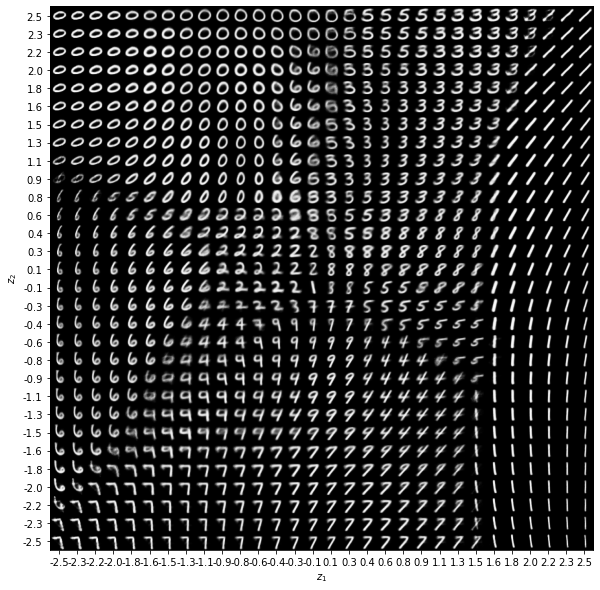

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = binary_crossentropy(inpt_vec,
                                          outputs)

reconstruction_loss *= inpt_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

hist = vae.fit(x_train,
               epochs=500,
               batch_size=500,
               validation_data=(x_test, None))

plot_results(models,
             data,
             batch_size=500,
             model_name="vae_mlp")


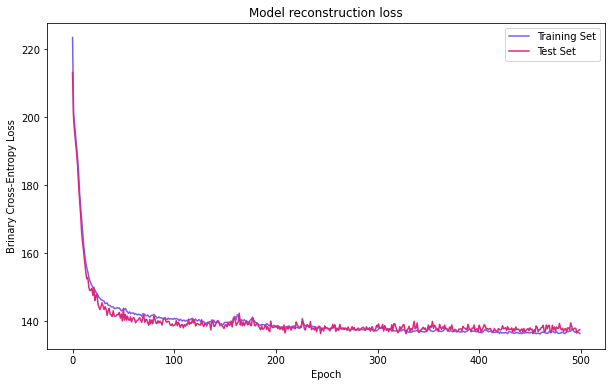

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model reconstruction loss')
# plt.yscale('log')
plt.ylabel('Brinary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('ch.9.vae.d.mnist.loss.png', dpi=350, bbox_inches='tight')
plt.show()


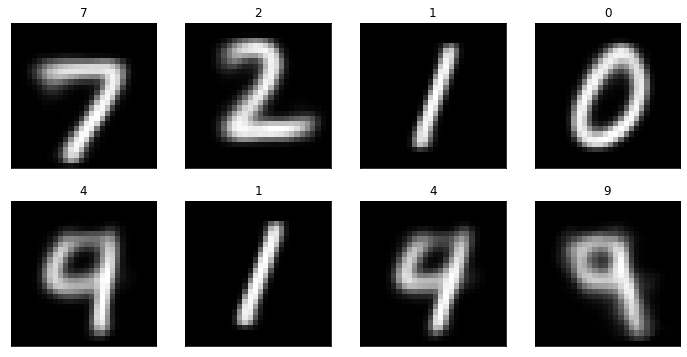

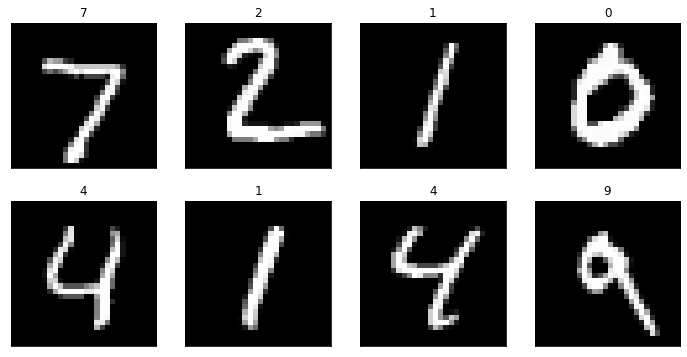

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

encdd = encoder.predict(x_test)
x_hat = decoder.predict(encdd[0])

plt.figure(figsize=(12,6))
for i, (img, y) in enumerate(zip(x_hat[0:8].reshape(8, 28, 28), y_test[0:8])):
  plt.subplot(241 + i)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(y)
plt.savefig('ch.9.mnist.21l.reconstructed.png', bbox_inches='tight', dpi=350)
plt.show()

plt.figure(figsize=(12,6))
for i, (img, y) in enumerate(zip(x_test[0:8].reshape(8, 28, 28), y_test[0:8])):
  plt.subplot(241 + i)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(y)
plt.savefig('ch.9.mnist.original.png', bbox_inches='tight', dpi=350)
plt.show()

(10000, 2)


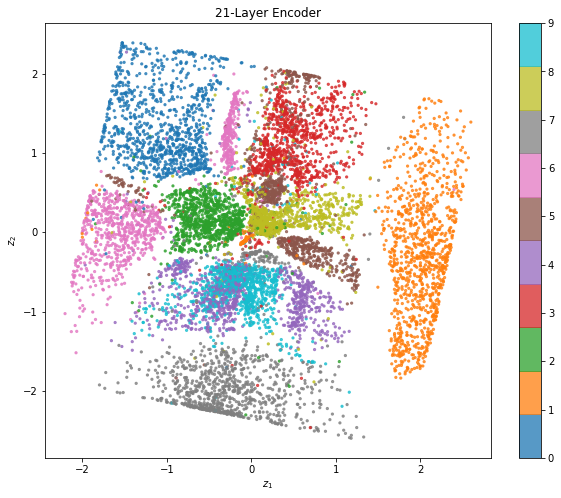

In [ ]:
import matplotlib.pyplot as plt

y_ = list(map(int, y_test))
X_ = encdd[0]

print(X_.shape)

plt.figure(figsize=(10,8))
plt.title('21-Layer Encoder')
plt.scatter(X_[:,0], X_[:,1], s=5.0, c=y_, alpha=0.75, cmap='tab10')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.colorbar()
plt.savefig('ch.9.minist.21l.png', bbox_inches='tight', dpi=350)

(10000, 2)


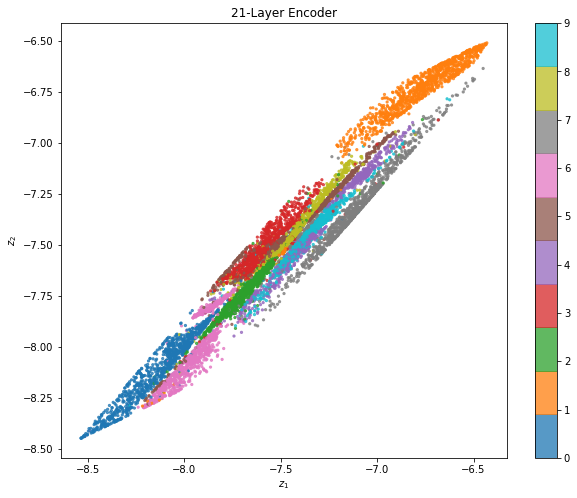

In [ ]:
import matplotlib.pyplot as plt

y_ = list(map(int, y_test))
X_ = encdd[1]

print(X_.shape)

plt.figure(figsize=(10,8))
plt.title('21-Layer Encoder')
plt.scatter(X_[:,0], X_[:,1], s=5.0, c=y_, alpha=0.75, cmap='tab10')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.colorbar()
plt.savefig('ch.9.minist.21l-.png', bbox_inches='tight', dpi=350)

(10000, 2)


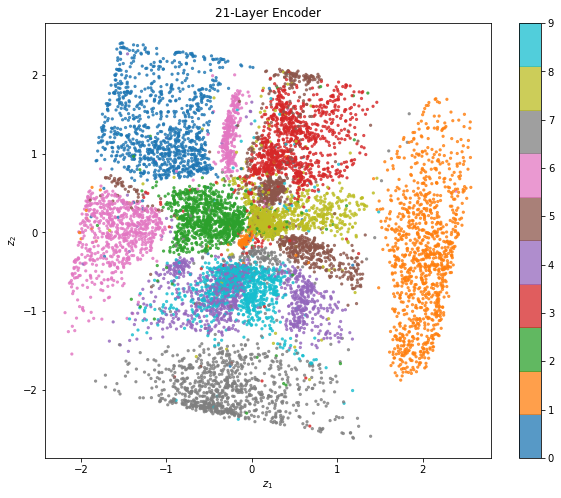

In [ ]:
import matplotlib.pyplot as plt

y_ = list(map(int, y_test))
X_ = encdd[2]

print(X_.shape)

plt.figure(figsize=(10,8))
plt.title('21-Layer Encoder')
plt.scatter(X_[:,0], X_[:,1], s=5.0, c=y_, alpha=0.75, cmap='tab10')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.colorbar()
plt.savefig('ch.9.minist.21l--.png', bbox_inches='tight', dpi=350)